# Improving WW3 predction with Machine Learning

First, install the requirements:

```bash
# create a new environment
conda create --name tf python=3.7
# activate your new environment
conda activate tf

# install tensorflow CPU version
conda install tensorflow=2
conda install tensorboard

# If you have a NVIDIA GPU installed and properly configured
conda install tensorflow-gpu=2
conda install tensorboard

# Natsort - better file sorting
conda install natsort

# Data I/O
import xarray as xr

# Classical machine learning
conda install pandas scikit-learn scikit-image

# Matplotlib and seaborn
conda install matplotlib seaborn

# make your life easier with ipython
conda install ipython
```

# 2 - Improving wave direction using the whole spectrum

In this second example, the model is trained with the full spectral information.

The target is still the measured wave direction.

## 2.1 Import the packages

In [1]:
import os

import datetime

import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from joblib import dump

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_context("paper", font_scale=1.25, rc={"lines.linewidth": 2.0})
sns.set_style("ticks", {"axes.linewidth": 2,
                        "legend.frameon": True,
                        "axes.facecolor": "#E9E9F1",
                        "grid.color": "w"})
mpl.rcParams["axes.linewidth"] = 2

## 2.2 - Define hyperparameters for the model

In [2]:
# Hyperparameters
TEST_SIZE = 0.3  # Fraction of data to use as test
RANDOM_STATE = 42  # State for reproducibility
MODEL = "SPC_MLP"  # Model name
STRATIFY = True  # make sure to use balanced dataset
LEARNING_RATE = 0.001
EPOCHS = 1024  # Number of epochs to train the model
LAYERS = 2  # Number hidden layers
NEURONS = 64 # Number of Neurons per layer
DROPOUT = 0.25  # Dropout rate between layers

# remove previous trained model, if any
# this model is fast to train, so no need to
# re-train from a previous run
if os.path.isfile("{}.h5".format(MODEL)):
    os.remove("{}.h5".format(MODEL))
if os.path.isfile("{}_xscaler.dat".format(MODEL)):
    os.remove("{}_xscaler.dat".format(MODEL))

## 2.3 - Load data

Colmuns ```769``` and ```771``` contain the observed and modelled direction data, column ```773``` contains the locations' ID, and columns from ```0``` to ```769``` are the spectral data.

In [3]:
# load the daaset
DATA = "spectral_data.csv"
inp = pd.read_csv(DATA, delimiter=",", header=None)
df = inp.iloc[:, -5:]  # these are the scalar variables
ds = inp.iloc[:, 1:-5]  # this are the training data

# covert Dm_obs and Dm_mod to radians so that it is a continous
# variable between -pi and pi

df["Dm_mod_rad"] = np.deg2rad(df[769]) - np.pi
df["Dm_obs_rad"] = np.deg2rad(df[771]) - np.pi
df["Dm_mod_angles"] = df[769]
df["Dm_obs_angles"] = df[771]

# compute the sin a cos, these are the target variables

df["Dm_mod_sinx"] = np.sin(df["Dm_mod_rad"])
df["Dm_mod_cosx"] = np.cos(df["Dm_mod_rad"])

df["Dm_obs_sinx"] = np.sin(df["Dm_obs_rad"])
df["Dm_obs_cosx"] = np.cos(df["Dm_obs_rad"])

In [4]:
print(ds.shape)

(51828, 768)


In [5]:
# get the dates from the dataframe with integrated parameters
df["Time_UTC"] = pd.read_csv("integrated_parameters.csv")["Time_UTC"]

## 2.4 - Prepare the training, testing and validation datasets

The biggest advantage here is that there is no need to define features to learn from. All the information we need is already in the spectrum.

In [6]:
X = ds.values

# prepare output array - Buoy data
y = df[["Dm_obs_sinx", "Dm_obs_cosx"]].values

# convert ID to int in order to preserve class PDF
# when doing the train/test split
df["ID"] = df[773]
if STRATIFY:
    df["labels"] = pd.factorize(df["ID"])[0].astype(np.uint16)
    labels = df["labels"].values
else:
    labels = np.ones(y.shape)

# split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE,
    shuffle=None)

# split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE,
    random_state=RANDOM_STATE, shuffle=True)

In [7]:
print("There are {} training samples, {} validation samples, and {} testing samples".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

There are 25395 training samples, 10884 validation samples, and 15549 testing samples


In [8]:
# scale data 0-1 interval
xscaler = MinMaxScaler().fit(X_train)
X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)
X_val = xscaler.transform(X_val)
X_all = xscaler.transform(X)
# save the scaler for later usage
dump(xscaler, "{}_xscaler.dat".format(MODEL))

['SPC_MLP_xscaler.dat']

## 2.5 - Define the Model

In [9]:
nlayers = int(LAYERS)
neurons = int(NEURONS)
drop_rate = float(DROPOUT)
layers = []

# add the input layer
layers.append(Dense(neurons, activation="relu",
              kernel_initializer="glorot_normal",
              input_shape=[X_train.shape[1]]))
layers.append(Dropout(drop_rate))

# add the other layers
for l in range(nlayers-1):
    layers.append(Dense(neurons, activation="relu"))
    layers.append(Dropout(drop_rate))

# add the output layer
layers.append(Dense(2, activation="tanh"))

# build the model
model = Sequential(layers)

optimizer = Adam(learning_rate=float(LEARNING_RATE))
model.compile(optimizer=optimizer,
              loss="mse",
              metrics=["mse"])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                49216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 53,506
Trainable params: 53,506
Non-trainable params: 0
_________________________________________________________________


## 2.6 - Train the model

In [10]:
history = model.fit(X_train, y_train,
                    batch_size=len(X_train),
                    epochs=int(EPOCHS),
                    verbose=1,
                    validation_data=(X_val, y_val))
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

Train on 25395 samples, validate on 10884 samples
Epoch 1/1024
25395/25395 [==============================] - 1s 33us/sample - loss: 0.7107 - mean_squared_error: 0.7107 - val_loss: 0.5773 - val_mean_squared_error: 0.5773
Epoch 2/1024
25395/25395 [==============================] - 0s 10us/sample - loss: 0.5883 - mean_squared_error: 0.5883 - val_loss: 0.4723 - val_mean_squared_error: 0.4723
Epoch 3/1024
25395/25395 [==============================] - 0s 18us/sample - loss: 0.4877 - mean_squared_error: 0.4877 - val_loss: 0.3896 - val_mean_squared_error: 0.3896
Epoch 4/1024
25395/25395 [==============================] - 0s 12us/sample - loss: 0.4047 - mean_squared_error: 0.4047 - val_loss: 0.3259 - val_mean_squared_error: 0.3259
Epoch 5/1024
25395/25395 [==============================] - 0s 11us/sample - loss: 0.3430 - mean_squared_error: 0.3430 - val_loss: 0.2760 - val_mean_squared_error: 0.2760
Epoch 6/1024
25395/25395 [==============================] - 0s 10us/sample - loss: 0.2930 - mea

Epoch 49/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0696 - mean_squared_error: 0.0696 - val_loss: 0.0514 - val_mean_squared_error: 0.0514
Epoch 50/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0695 - mean_squared_error: 0.0695 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 51/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0684 - mean_squared_error: 0.0684 - val_loss: 0.0505 - val_mean_squared_error: 0.0505
Epoch 52/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0667 - mean_squared_error: 0.0667 - val_loss: 0.0500 - val_mean_squared_error: 0.0500
Epoch 53/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.0494 - val_mean_squared_error: 0.0494
Epoch 54/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0655 - mean_squared_error: 0.0655 - val_loss: 0.0486 - val_m

Epoch 97/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 98/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 99/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 100/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 101/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 102/1024
25395/25395 [==============================] - 0s 7us/sample - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0301 - va

Epoch 145/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 146/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 147/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 148/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 149/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 150/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0204 -

Epoch 193/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 194/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 195/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 196/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 197/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 198/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0168 -

Epoch 241/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 242/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 243/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 244/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 245/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 246/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0149 -

Epoch 289/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 290/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 291/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 292/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 293/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 294/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0136 -

Epoch 337/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 338/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 339/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 340/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 341/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 342/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0126 -

Epoch 385/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 386/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 387/1024
25395/25395 [==============================] - 0s 8us/sample - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 388/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 389/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 390/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0118 -

Epoch 433/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 434/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 435/1024
25395/25395 [==============================] - 0s 7us/sample - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 436/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 437/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 438/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0112 -

Epoch 481/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 482/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 483/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 484/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 485/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 486/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0107 -

Epoch 529/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 530/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 531/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 532/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 533/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 534/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0103 -

Epoch 577/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 578/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 579/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 580/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 581/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 582/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0100 -

Epoch 625/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 626/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 627/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 628/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 629/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 630/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0098 -

Epoch 673/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 674/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 675/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 676/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 677/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 678/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0095 -

Epoch 721/1024
25395/25395 [==============================] - 0s 8us/sample - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 722/1024
25395/25395 [==============================] - 0s 7us/sample - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 723/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 724/1024
25395/25395 [==============================] - 0s 8us/sample - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 725/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 726/1024
25395/25395 [==============================] - 0s 7us/sample - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0093 -

Epoch 769/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 770/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 771/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 772/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 773/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 774/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0091 -

Epoch 817/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 818/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 819/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 820/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 821/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 822/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0089 -

Epoch 865/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 866/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 867/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 868/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 869/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 870/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0087 -

Epoch 913/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 914/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 915/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 916/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 917/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 918/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0086 -

Epoch 961/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 962/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 963/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 964/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 965/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 966/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0084 -

Epoch 1009/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 1010/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 1011/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 1012/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 1013/1024
25395/25395 [==============================] - 0s 6us/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 1014/1024
25395/25395 [==============================] - 0s 5us/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.

In [11]:
# save model to file
print("\n - Saving model to file")
model.save("{}.h5".format(MODEL))
hist.to_csv("{}_history.csv".format(MODEL))
print("model saved!")


 - Saving model to file
model saved!


In [12]:
# predict
y_pred = np.squeeze(model.predict(X_test))

# convert back to radians
y_pred_rescaled = np.arctan2(y_pred[:, 0], y_pred[:, 1])
y_test_rescaled = np.arctan2(y_test[:, 0], y_test[:, 1])

print("\n - Results (in radians)")
print("\n   WW3")
ww3_r2 = r2_score(df["Dm_mod_rad"].values,
                  df["Dm_obs_rad"].values)
print("     r2-score:", round(ww3_r2, 2))
ww3_rmse = np.sqrt(mean_squared_error(df["Dm_mod_rad"].values,
                                      df["Dm_obs_rad"].values))
print("     rmse:", round(ww3_rmse, 2))
ww3_mae = mean_absolute_error(df["Dm_mod_rad"].values,
                              df["Dm_obs_rad"].values)
print("     mae", round(ww3_mae, 2))

print("\n   MLP")
mlp_r2 = r2_score(y_pred_rescaled, y_test_rescaled)
print("     r2-score:", round(mlp_r2, 2))
mlp_rmse = np.sqrt(mean_squared_error(y_pred_rescaled,
                                      y_test_rescaled))
print("     rmse:", round(mlp_rmse, 2))
mlp_mae = mean_absolute_error(y_pred_rescaled, y_test_rescaled)
print("     mae", round(mlp_mae, 2))

# apply the transformation to all data
X_all = xscaler.transform(X)
y_pred_all = np.squeeze(model.predict(X_all))
y_pred_radians = np.arctan2(y_pred_all[:, 0], y_pred_all[:, 1])


 - Results (in radians)

   WW3
     r2-score: 0.04
     rmse: 0.31
     mae 0.24

   MLP
     r2-score: 0.87
     rmse: 0.12
     mae 0.1


## 2.7 - Plot the results

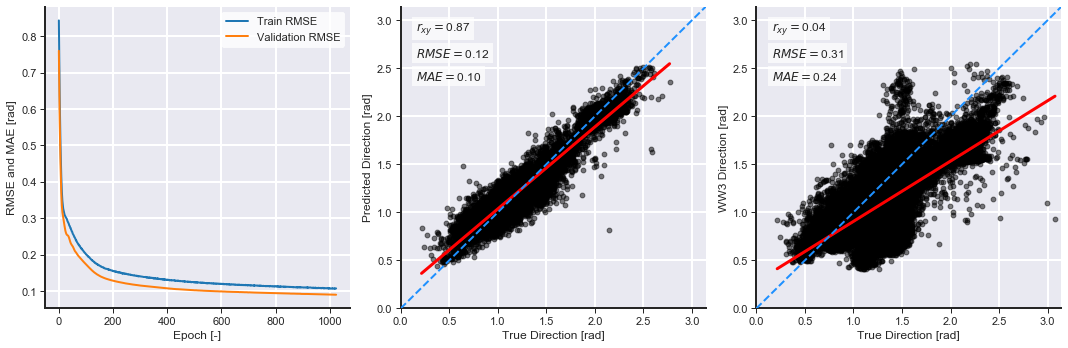

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(hist["epoch"], np.sqrt(hist["mean_squared_error"]), label="Train RMSE")
ax1.plot(hist["epoch"], np.sqrt(hist["val_mean_squared_error"]), label="Validation RMSE")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("RMSE [rad]")

lg = ax1.legend()
lg.get_frame().set_color("w")

ax1.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax1)

ax1.set_ylabel("RMSE and MAE [rad]")
ax1.set_xlabel("Epoch [-]")

sns.regplot(y_test_rescaled, y_pred_rescaled, ax=ax2, truncate=True,
            color="r", scatter_kws={"color": "k", "alpha": 0.5})
ax2.plot((0, 10), (0, 10), color="dodgerblue", ls="--", lw=2, zorder=10)

ax2.set_xlabel("True Direction [rad]")
ax2.set_ylabel("Predicted Direction [rad]")

ax2.set_xlim(0, 3.14)
ax2.set_ylim(0, 3.14)

ax2.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax2)

bbox = dict(boxstyle="square", ec="none", fc="1", lw=1, alpha=0.7)
txt = r"$r_{xy}=$"+"{0:.2f}".format(mlp_r2)
ax2.text(0.05, 0.9, txt, transform=ax2.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$RMSE=$"+"{0:.2f}".format(mlp_rmse)
ax2.text(0.05, 0.825, txt, transform=ax2.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$MAE=$"+"{0:.2f}".format(mlp_mae)
ax2.text(0.05, 0.75, txt, transform=ax2.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)

# plot WW3 results
y_ww3_rescaled = np.arctan2(df["Dm_mod_sinx"].values,
                            df["Dm_mod_cosx"].values)
y_obs_rescaled = np.arctan2(df["Dm_obs_sinx"].values,
                            df["Dm_obs_cosx"].values)
sns.regplot(y_obs_rescaled, y_ww3_rescaled, ax=ax3, truncate=True,
            color="r", scatter_kws={"color": "k", "alpha": 0.5})
ax3.plot((0, 10), (0, 10), color="dodgerblue", ls="--", lw=2, zorder=10)

ax3.set_xlim(0, 3.14)
ax3.set_ylim(0, 3.14)

ax3.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax3)

bbox = dict(boxstyle="square", ec="none", fc="1", lw=1, alpha=0.7)
txt = r"$r_{xy}=$"+"{0:.2f}".format(ww3_r2)
ax3.text(0.05, 0.9, txt, transform=ax3.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$RMSE=$"+"{0:.2f}".format(ww3_rmse)
ax3.text(0.05, 0.825, txt, transform=ax3.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$MAE=$"+"{0:.2f}".format(ww3_mae)
ax3.text(0.05, 0.75, txt, transform=ax3.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)

ax3.set_xlabel("True Direction [rad]")
ax3.set_ylabel("WW3 Direction [rad]")

# finalyse
fig.tight_layout()
plt.show()

In [14]:
y_pred = np.squeeze(model.predict(X_all))
y_pred_angles = np.rad2deg(np.arctan2(y_pred[:, 0], y_pred[:, 1]) + np.pi)
df["prediction"] = y_pred_angles
dfl = df.loc[df["ID"] == "ALebu"]

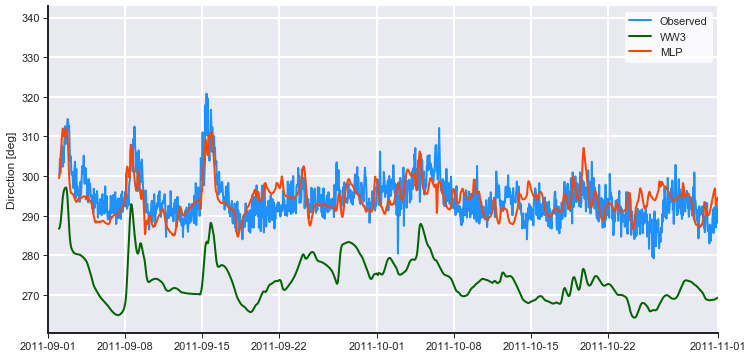

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

x = pd.to_datetime(dfl["Time_UTC"].values).to_pydatetime()
ytrue = dfl["Dm_obs_angles"].values
ymod =  dfl["Dm_mod_angles"].values
ymlp = dfl["prediction"].values

ax.plot(x, ytrue, color="dodgerblue", label="Observed")
ax.plot(x, ymod, color="darkgreen", label="WW3")
ax.plot(x, ymlp, color="orangered", label="MLP")

ax.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax)

ax.set_ylabel("Direction [deg]")

lg = ax.legend(loc=1)
lg.get_frame().set_color("w")

ax.set_xlim(datetime.datetime(2011, 9, 1), datetime.datetime(2011, 11, 1))

plt.show()

In [16]:
df.to_csv("SPC_MLP_PREDICTIONS.csv")

Not bad! Can you we improve these results with a CNN?